Performed for a run where the original graphs were run for 100 batchs

In [1]:
%load_ext autoreload
%autoreload 2
import logging
import os
import pickle
from os.path import join as pj

import numpy as np
import pandas as pd
import torch
from sae_lens import SAE, ActivationsStore
from transformer_lens import HookedTransformer

from sae_cooccurrence.graph_generation import (
    load_subgraph,
    plot_subgraph_static,
)
from sae_cooccurrence.normalised_cooc_functions import (
    get_sae_release,
    neat_sae_id,
)
from sae_cooccurrence.pca import (
    analyze_representative_points,
    analyze_specific_points,
    calculate_pca_decoder,
    create_pca_plots_decoder,
    generate_data,
    load_data_from_pickle,
    plot_doubly_clustered_activation_heatmap,
    plot_pca_explanation_and_save,
    plot_pca_feature_strength,
    plot_pca_with_active_features,
    plot_pca_with_top_feature,
    plot_simple_scatter,
    plot_token_pca_and_save,
    save_data_to_pickle,
)
from sae_cooccurrence.utils.saving_loading import load_npz_files, set_device
from sae_cooccurrence.utils.set_paths import get_git_root

# Set up logging and paths


In [3]:
def setup_logging(log_path):
    logging.basicConfig(
        filename=log_path,
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
    )


# Config -------------
torch.set_grad_enabled(False)
device = set_device()
git_root = get_git_root()

Using MPS


# Settings to perform PCA on a particular subgraph

In [4]:
save_figs = True

# model_name = "gpt2-small"
# sae_release_short = "res-jb-feature-splitting"
# sae_id = "blocks.8.hook_resid_pre_24576"
# n_batches_reconstruction = 25

model_name = "gemma-2-2b"
sae_release_short = "gemma-scope-2b-pt-res-canonical"
sae_id = "layer_18/width_16k/canonical"
n_batches_reconstruction = 100
remove_special_tokens = True

activation_threshold = 1.5
subgraph_id = 59

In [5]:
np.random.seed(1234)

fs_splitting_cluster = subgraph_id
pca_prefix = "pca"

# Load model
model = HookedTransformer.from_pretrained(model_name, device=device)

# Process the specific subgraph
sae_id_neat = neat_sae_id(sae_id)
results_dir = f"results/{model_name}/{sae_release_short}/{sae_id_neat}"
results_path = pj(git_root, results_dir)
activation_threshold_safe = str(activation_threshold).replace(".", "_")

figures_path = pj(git_root, f"figures/{model_name}/{sae_release_short}/{sae_id_neat}")
pca_dir = f"{pca_prefix}_{activation_threshold_safe}_subgraph_{subgraph_id}"
pca_path = pj(figures_path, pca_dir)
if not os.path.exists(pca_path):
    os.makedirs(pca_path)
pickle_file = pj(pca_path, f"pca_data_subgraph_{subgraph_id}.pkl")

# Set up logging
log_path = pj(pca_path, "pca_analysis.log")
setup_logging(log_path)

# Log all settings
logging.info("Script started")
logging.info("Settings:")
logging.info(f"  save_figs: {save_figs}")
logging.info(f"  git_root: {git_root}")
logging.info(f"  sae_id: {sae_id}")
logging.info(f"  activation_threshold: {activation_threshold}")
logging.info(f"  subgraph_id: {subgraph_id}")
logging.info(f"  fs_splitting_cluster: {fs_splitting_cluster}")
logging.info(f"  pca_prefix: {pca_prefix}")
logging.info(f"  model_name: {model_name}")
logging.info(f"  sae_release_short: {sae_release_short}")
logging.info(f"  n_batches_reconstruction: {n_batches_reconstruction}")
logging.info(f"  device: {device}")
logging.info(f"  results_path: {results_path}")
logging.info(f"  pca_path: {pca_path}")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b into HookedTransformer


In [6]:
node_df = pd.read_csv(
    pj(results_path, f"dataframes/node_info_df_{activation_threshold_safe}.csv")
)
logging.info(
    f"Loaded node_df from {pj(results_path, f'dataframes/node_info_df_{activation_threshold_safe}.csv')}"
)

overall_feature_activations = load_npz_files(
    results_path, "feature_acts_cooc_activations"
).get(activation_threshold)

# with open(pj(results_path, f"subgraph_objects/activation_{activation_threshold_safe}/subgraph_{subgraph_id}.pkl"), 'rb') as f:
#     subgraph = pickle.load(f)


# Filter for the specific subgraph
fs_splitting_nodes = node_df.query("subgraph_id == @subgraph_id")["node_id"].tolist()

Loading npz files:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
regen_data = True
if not regen_data:
    raise ValueError("Are you sure you don't want to use existing data?")

In [12]:
if not regen_data and os.path.exists(pickle_file):
    data = load_data_from_pickle(pickle_file)
    results = data["results"]
    pca_df = data["pca_df"]
    pca = data["pca"]
    pca_decoder = data["pca_decoder"]
    pca_decoder_df = data["pca_decoder_df"]
else:
    sae_release = get_sae_release(model_name, sae_release_short)

    # Load SAE and set up activation store
    sae, cfg_dict, sparsity = SAE.from_pretrained(
        release=sae_release, sae_id=sae_id, device=device
    )
    sae.fold_W_dec_norm()

    activation_store = ActivationsStore.from_sae(
        model=model,
        sae=sae,
        streaming=True,
        store_batch_size_prompts=8,
        train_batch_size_tokens=4096,
        n_batches_in_buffer=32,
        device=device,
    )

    data = generate_data(
        model,
        sae,
        activation_store,
        fs_splitting_nodes,
        n_batches_reconstruction,
        decoder=False,
        remove_special_tokens=remove_special_tokens,
        device=device,
    )

    if regen_data:
        save_data_to_pickle(data, pickle_file)

    results = data["results"]
    pca_df = data["pca_df"]
    pca = data["pca"]
    pca_decoder = data["pca_decoder"]
    pca_decoder_df = data["pca_decoder_df"]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/matthew/Library/Caches/pypoetry/virtualenvs/sae-cooccurence-DZTJ6ajw-py3.11/lib/python3.11/site-packages/sae_lens/training/activations_store.py:245: UserWarning:

Dataset is not tokenized. Pre-tokenizing will improve performance and allows for more control over special tokens. See https://jbloomaus.github.io/SAELens/training_saes/#pretokenizing-datasets for more info.



  0%|          | 0/100 [00:00<?, ?it/s]

Total examples found: 2517


In [9]:
# # Save pca_df as CSV
# pca_df_filename = f"pca_df_subgraph_{subgraph_id}.csv"
# pca_df.to_csv(pj(pca_path, pca_df_filename), index=False)

plot_token_pca_and_save(pca_df, pca_path, subgraph_id, color_by="token", save=save_figs)

plot_pca_explanation_and_save(pca, pca_path, subgraph_id, save=save_figs)

plot_simple_scatter(results, pca_path, subgraph_id, fs_splitting_nodes, save=save_figs)

if pca_decoder is not None:
    pca_decoder, pca_decoder_df = calculate_pca_decoder(sae, fs_splitting_nodes)
    # Save pca_decoder_df as CSV
    pca_decoder_df_filename = f"pca_decoder_df_subgraph_{subgraph_id}.csv"
    pca_decoder_df.to_csv(pj(pca_path, pca_decoder_df_filename), index=False)

    create_pca_plots_decoder(pca_decoder_df, subgraph_id, pca_path, save=save_figs)

print(f"Processing completed for subgraph ID {subgraph_id}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Processing completed for subgraph ID 59


In [11]:
plot_pca_with_top_feature(
    pca_df, results, fs_splitting_nodes, fs_splitting_cluster, pca_path, save=save_figs
)

In [18]:
plot_pca_feature_strength(
    pca_df,
    results,
    fs_splitting_nodes,
    fs_splitting_cluster,
    pca_path,
    pc_x="PC1",
    pc_y="PC2",
    save=save_figs,
)
plot_pca_feature_strength(
    pca_df,
    results,
    fs_splitting_nodes,
    fs_splitting_cluster,
    pca_path,
    pc_x="PC1",
    pc_y="PC3",
    save=save_figs,
)
plot_pca_feature_strength(
    pca_df,
    results,
    fs_splitting_nodes,
    fs_splitting_cluster,
    pca_path,
    pc_x="PC2",
    pc_y="PC3",
    save=save_figs,
)

In [11]:
plot_pca_with_active_features(
    pca_df,
    results,
    fs_splitting_nodes,
    fs_splitting_cluster,
    pca_path,
    activation_threshold=activation_threshold,
    save=save_figs,
)

In [12]:
plot_doubly_clustered_activation_heatmap(
    results,
    fs_splitting_nodes,
    pca_df,
    pca_path,
    fs_splitting_cluster,
    max_examples=1000,
    save=save_figs,
)

In [19]:
analyze_representative_points(
    results=results,
    fs_splitting_nodes=fs_splitting_nodes,
    fs_splitting_cluster=fs_splitting_cluster,
    activation_threshold=activation_threshold,
    node_df=node_df,
    results_path=results_path,
    pca_df=pca_df,
    save_figs=True,
    pca_path=pca_path,
)


Analyzing representative point 1:


/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Number of non-zero features: 39
Number of non-zero feature splitting nodes: 1
Total number of feature splitting nodes: 5
Mean activation of non-zero feature splitting nodes: 0.3027
Mean activation of non-zero non-feature splitting nodes: 3.2734
Median activation of non-zero feature splitting nodes: 0.3027
Median activation of non-zero non-feature splitting nodes: 1.1038
Number of splitting features active above threshold: 0
Number of non-splitting features active above threshold: 15
Sum of activation strengths for splitting features: 0.3027
Sum of activation strengths for non-splitting features: 124.3899

Analyzing representative point 2:


Number of non-zero features: 23
Number of non-zero feature splitting nodes: 1
Total number of feature splitting nodes: 5
Mean activation of non-zero feature splitting nodes: 0.4615
Mean activation of non-zero non-feature splitting nodes: 4.6290
Median activation of non-zero feature splitting nodes: 0.4615
Median activation of non-zero non-feature splitting nodes: 1.4941
Number of splitting features active above threshold: 0
Number of non-splitting features active above threshold: 11
Sum of activation strengths for splitting features: 0.4615
Sum of activation strengths for non-splitting features: 101.8379

Analyzing representative point 3:


/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Number of non-zero features: 55
Number of non-zero feature splitting nodes: 1
Total number of feature splitting nodes: 5
Mean activation of non-zero feature splitting nodes: 1.2277
Mean activation of non-zero non-feature splitting nodes: 2.9216
Median activation of non-zero feature splitting nodes: 1.2277
Median activation of non-zero non-feature splitting nodes: 1.2821
Number of splitting features active above threshold: 0
Number of non-splitting features active above threshold: 26
Sum of activation strengths for splitting features: 1.2277
Sum of activation strengths for non-splitting features: 157.7681

Analyzing representative point 4:


/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Number of non-zero features: 55
Number of non-zero feature splitting nodes: 1
Total number of feature splitting nodes: 5
Mean activation of non-zero feature splitting nodes: 1.2277
Mean activation of non-zero non-feature splitting nodes: 2.9216
Median activation of non-zero feature splitting nodes: 1.2277
Median activation of non-zero non-feature splitting nodes: 1.2821
Number of splitting features active above threshold: 0
Number of non-splitting features active above threshold: 26
Sum of activation strengths for splitting features: 1.2277
Sum of activation strengths for non-splitting features: 157.7681

Analyzing representative point 5:


/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:624: UserWarning:

Glyph 29256 (\N{CJK UNIFIED IDEOGRAPH-7248}) missing from font(s) DejaVu Sans.

/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:625: UserWarning:

Glyph 29256 (\N{CJK UNIFIED IDEOGRAPH-7248}) missing from font(s) DejaVu Sans.

/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:625: UserWarning:

Glyph 29256 (\N{CJK UNIFIED IDEOGRAPH-7248}) missing from font(s) DejaVu Sans.

/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:626: UserWarning:

Glyph 29256 (\N{CJK UNIFIED IDEOGRAPH-7248}) missing from font(s) DejaVu Sans.

/Users/matthew/Documents/Github/sae_cooccurrence/sae_c

Number of non-zero features: 44
Number of non-zero feature splitting nodes: 1
Total number of feature splitting nodes: 5
Mean activation of non-zero feature splitting nodes: 1.6251
Mean activation of non-zero non-feature splitting nodes: 3.3963
Median activation of non-zero feature splitting nodes: 1.6251
Median activation of non-zero non-feature splitting nodes: 1.1159
Number of splitting features active above threshold: 1
Number of non-splitting features active above threshold: 19
Sum of activation strengths for splitting features: 1.6251
Sum of activation strengths for non-splitting features: 146.0398


In [23]:
# After creating the PCA plot and identifying interesting points
interesting_point_ids = [0]  # Replace with actual IDs of interest
analyze_specific_points(
    results,
    fs_splitting_nodes,
    fs_splitting_cluster,
    activation_threshold,
    node_df,
    results_path,
    pca_df,
    interesting_point_ids,
    save_figs=True,
    pca_path=pca_path,
)


Analyzing point with ID 0:


/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



In [35]:
plot_subgraph_static(
    subgraph=load_subgraph(results_path, activation_threshold, subgraph_id),
    node_info_df=node_df,
    output_path=os.path.join(pca_path, "overall_subgraph"),
    activation_array=overall_feature_activations,
    normalize_globally=False,
    save_figs=True,
)

/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



In [23]:
def plot_pca_preceding_words(pca_df, pca_path, fs_splitting_cluster, save_figs=False):
    import re

    import matplotlib.pyplot as plt
    import seaborn as sns

    # Vectorize the context cleaning operation
    # Clean LaTeX and special characters
    def clean_text(text):
        # Remove LaTeX math mode content
        text = re.sub(r"\$.*?\$", "", text)
        # # Remove other special characters as needed
        # text = re.sub(r'[^\w\s]', '', text)
        return text.strip()

    pca_df["cleaned_context"] = (
        pca_df["context"].str.replace("<|endoftext|>", "").apply(clean_text)
    )

    # More efficient preceding word extraction using pandas operations
    def extract_preceding_word_vectorized(row):
        try:
            parts = row["cleaned_context"].split(f"|{row['tokens']}|")
            if len(parts) < 2:
                return None
            words = parts[0].strip().split()
            return words[-1] if words else None
        except Exception:
            return None

    # Apply the function more efficiently
    pca_df["preceding_word"] = pca_df.apply(extract_preceding_word_vectorized, axis=1)

    # Filter once and create a view
    pca_df_filtered = pca_df.dropna(subset=["preceding_word"])

    # Optional: limit to top N most common preceding words
    top_n = 100  # adjust this number as needed
    top_words = pca_df_filtered["preceding_word"].value_counts().nlargest(top_n).index
    pca_df_filtered = pca_df_filtered[pca_df_filtered["preceding_word"].isin(top_words)]

    # Create the plot
    plt.figure(figsize=(12, 8))

    # Use seaborn's scatterplot for automatic color handling
    sns.scatterplot(
        data=pca_df_filtered,
        x="PC2",
        y="PC3",
        hue="preceding_word",
        alpha=0.6,
        s=50,  # marker size
    )

    plt.title(f"PCA Analysis - Cluster {fs_splitting_cluster} (By Preceding Word)")
    plt.xlabel("PC2")
    plt.ylabel("PC3")

    # Adjust legend with smaller font
    plt.legend(
        bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0, fontsize="small"
    )

    # Use bbox_inches='tight' in tight_layout to handle legend
    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/pca_plot_preceding_words_static_{fs_splitting_cluster}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_13318/4074480086.py:60: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



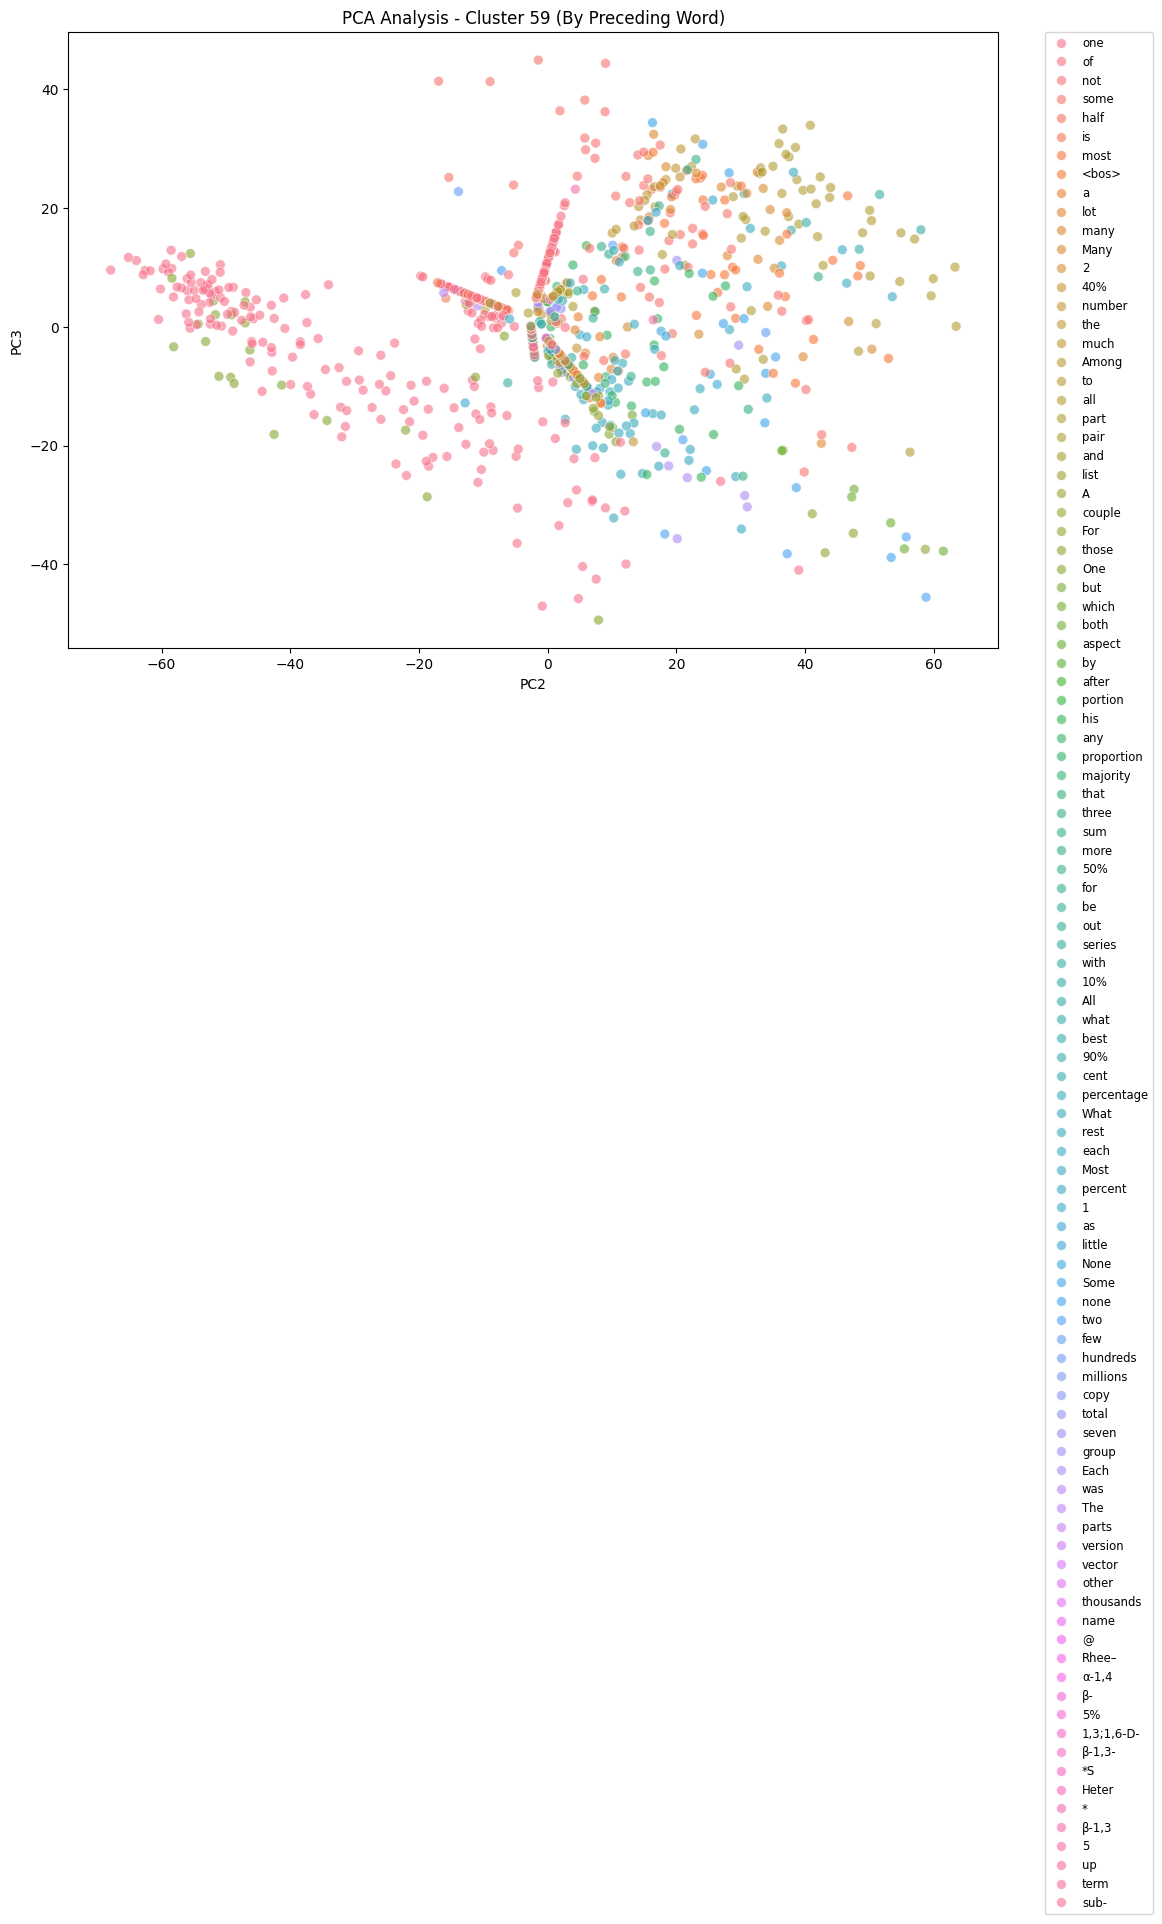

In [24]:
plot_pca_preceding_words(pca_df, pca_path, fs_splitting_cluster, save_figs)

In [26]:
def plot_pca_years(pca_df, pca_path, fs_splitting_cluster, save_figs=False):
    import re

    import matplotlib.pyplot as plt

    # Function to extract year from context
    def extract_year(context):
        # Look for 4-digit numbers that could be years
        context = context.replace("|", "")
        years = re.findall(r"\b(1[89][0-9]{2}|20[0-2][0-9])\b", context)
        if years:
            # If multiple years found, take the closest one to the token
            # (for now, just taking the first one found)
            return int(years[0])
        return None

    # Clean context and extract years
    pca_df["cleaned_context"] = pca_df["context"].str.replace("<|endoftext|>", "")
    pca_df["year"] = pca_df["cleaned_context"].apply(extract_year)

    # Create figure
    plt.figure(figsize=(12, 8))

    # Plot non-year points first (grey and translucent)
    non_year_mask = pca_df["year"].isna()
    plt.scatter(
        pca_df.loc[non_year_mask, "PC2"],
        pca_df.loc[non_year_mask, "PC3"],
        color="grey",
        alpha=0.2,
        s=50,
        label="No year in context",
    )

    # Plot year points with a colormap
    year_mask = ~non_year_mask
    if year_mask.any():
        scatter = plt.scatter(
            pca_df.loc[year_mask, "PC2"],
            pca_df.loc[year_mask, "PC3"],
            c=pca_df.loc[year_mask, "year"],
            cmap="viridis",
            alpha=0.6,
            s=50,
        )
        plt.colorbar(scatter, label="Year in Context")

    plt.title(
        f"PCA Analysis - Cluster {fs_splitting_cluster} (Colored by Year in Context)"
    )
    plt.xlabel("PC2")
    plt.ylabel("PC3")

    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/pca_plot_years_static_{fs_splitting_cluster}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()

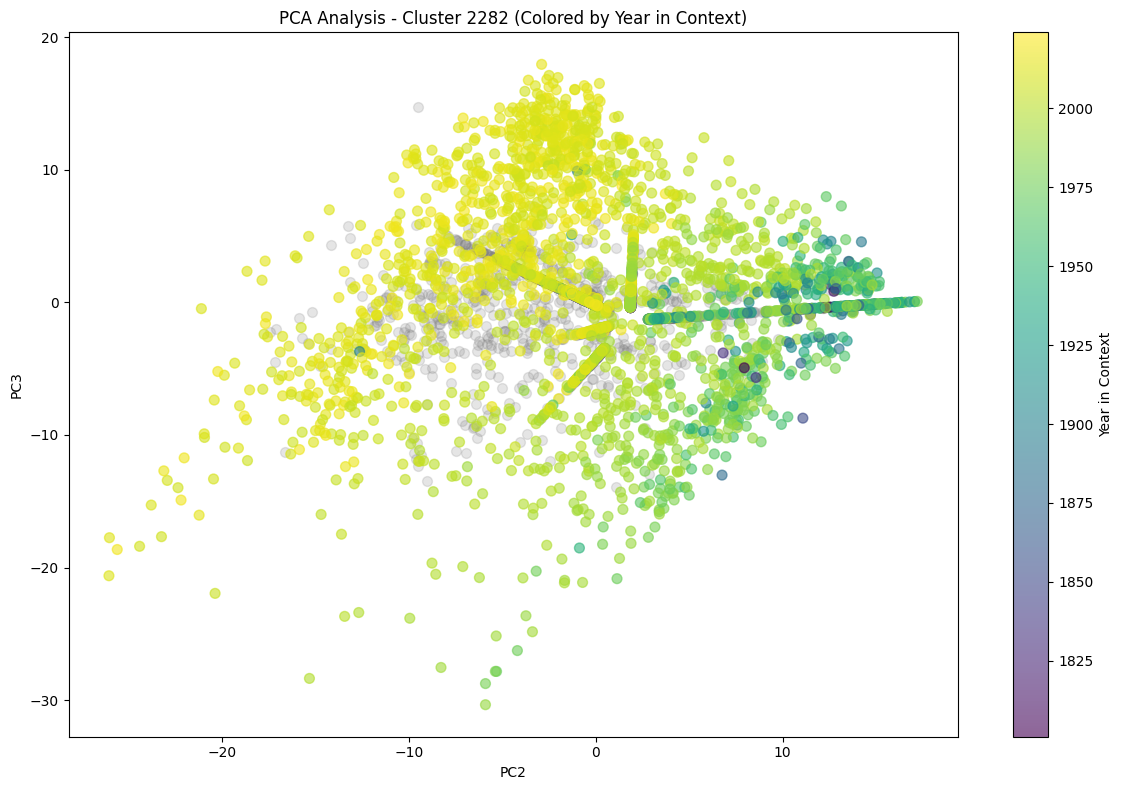

In [27]:
plot_pca_years(pca_df, pca_path, fs_splitting_cluster, save_figs)

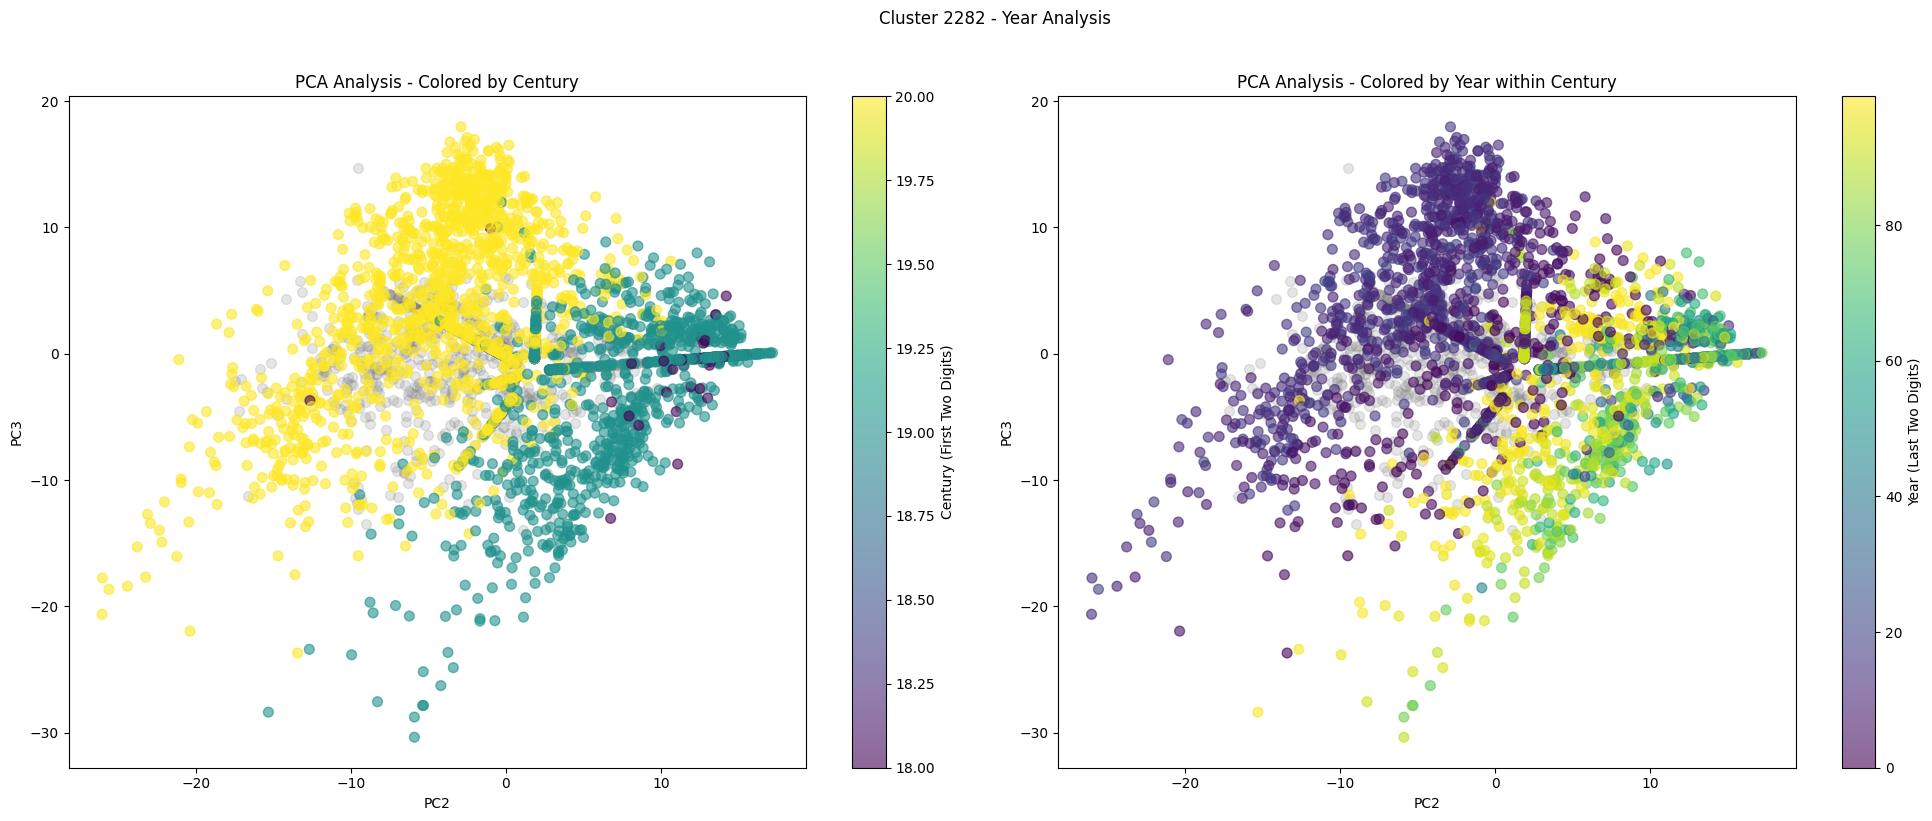

In [28]:
def plot_pca_year_parts(pca_df, pca_path, fs_splitting_cluster, save_figs=False):
    import re

    import matplotlib.pyplot as plt

    # Function to extract year and its parts from context
    def extract_year_parts(context):
        context = context.replace("|", "")
        years = re.findall(r"\b(1[89][0-9]{2}|20[0-2][0-9])\b", context)
        if years:
            year = int(years[0])
            return {
                "year": year,
                "century_part": year // 100,  # First two digits
                "year_part": year % 100,  # Last two digits
            }
        return None

    # Clean context and extract year parts
    pca_df["cleaned_context"] = pca_df["context"].str.replace("<|endoftext|>", "")
    year_parts = pca_df["cleaned_context"].apply(extract_year_parts)

    # Convert year parts to separate columns
    pca_df["century_part"] = year_parts.apply(
        lambda x: x["century_part"] if x else None
    )
    pca_df["year_part"] = year_parts.apply(lambda x: x["year_part"] if x else None)

    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot 1: First two digits (century)
    non_year_mask = pca_df["century_part"].isna()
    ax1.scatter(
        pca_df.loc[non_year_mask, "PC2"],
        pca_df.loc[non_year_mask, "PC3"],
        color="grey",
        alpha=0.2,
        s=50,
        label="No year",
    )

    year_mask = ~non_year_mask
    if year_mask.any():
        scatter1 = ax1.scatter(
            pca_df.loc[year_mask, "PC2"],
            pca_df.loc[year_mask, "PC3"],
            c=pca_df.loc[year_mask, "century_part"],
            cmap="viridis",
            alpha=0.6,
            s=50,
        )
        plt.colorbar(scatter1, ax=ax1, label="Century (First Two Digits)")

    ax1.set_title("PCA Analysis - Colored by Century")
    ax1.set_xlabel("PC2")
    ax1.set_ylabel("PC3")

    # Plot 2: Last two digits
    ax2.scatter(
        pca_df.loc[non_year_mask, "PC2"],
        pca_df.loc[non_year_mask, "PC3"],
        color="grey",
        alpha=0.2,
        s=50,
        label="No year",
    )

    if year_mask.any():
        scatter2 = ax2.scatter(
            pca_df.loc[year_mask, "PC2"],
            pca_df.loc[year_mask, "PC3"],
            c=pca_df.loc[year_mask, "year_part"],
            cmap="viridis",
            alpha=0.6,
            s=50,
        )
        plt.colorbar(scatter2, ax=ax2, label="Year (Last Two Digits)")

    ax2.set_title("PCA Analysis - Colored by Year within Century")
    ax2.set_xlabel("PC2")
    ax2.set_ylabel("PC3")

    plt.suptitle(f"Cluster {fs_splitting_cluster} - Year Analysis", y=1.02)
    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/pca_plot_year_parts_static_{fs_splitting_cluster}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()


# Call the function
plot_pca_year_parts(pca_df, pca_path, fs_splitting_cluster, save_figs)

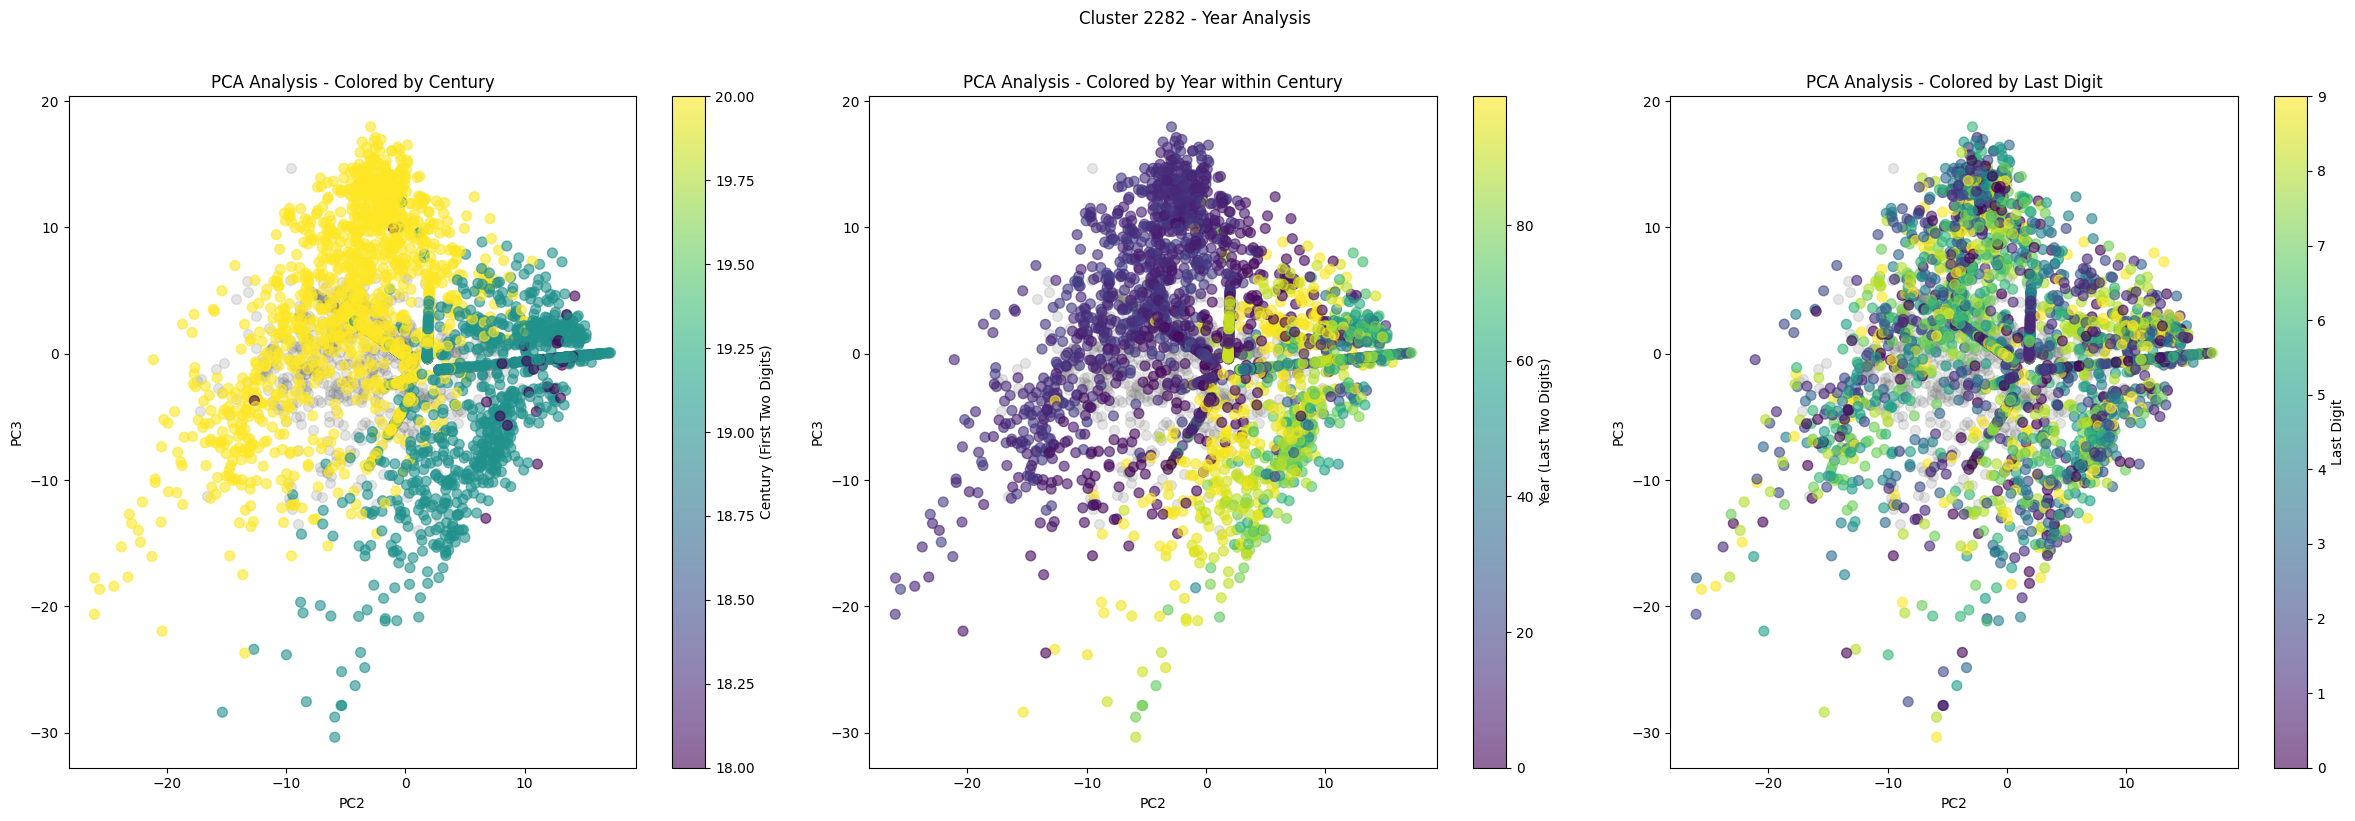

In [30]:
def plot_pca_year_parts(pca_df, pca_path, fs_splitting_cluster, save_figs=False):
    import re

    import matplotlib.pyplot as plt

    # Function to extract year and its parts from context
    def extract_year_parts(context):
        context = context.replace("|", "")
        years = re.findall(r"\b(1[89][0-9]{2}|20[0-2][0-9])\b", context)
        if years:
            year = int(years[0])
            return {
                "year": year,
                "century_part": year // 100,  # First two digits
                "year_part": year % 100,  # Last two digits
                "last_digit": year % 10,  # Last digit
            }
        return None

    # Clean context and extract year parts
    pca_df["cleaned_context"] = pca_df["context"].str.replace("<|endoftext|>", "")
    year_parts = pca_df["cleaned_context"].apply(extract_year_parts)

    # Convert year parts to separate columns
    pca_df["century_part"] = year_parts.apply(
        lambda x: x["century_part"] if x else None
    )
    pca_df["year_part"] = year_parts.apply(lambda x: x["year_part"] if x else None)
    pca_df["last_digit"] = year_parts.apply(lambda x: x["last_digit"] if x else None)

    # Create three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

    # Plot 1: First two digits (century)
    non_year_mask = pca_df["century_part"].isna()
    ax1.scatter(
        pca_df.loc[non_year_mask, "PC2"],
        pca_df.loc[non_year_mask, "PC3"],
        color="grey",
        alpha=0.2,
        s=50,
        label="No year",
    )

    year_mask = ~non_year_mask
    if year_mask.any():
        scatter1 = ax1.scatter(
            pca_df.loc[year_mask, "PC2"],
            pca_df.loc[year_mask, "PC3"],
            c=pca_df.loc[year_mask, "century_part"],
            cmap="viridis",
            alpha=0.6,
            s=50,
        )
        plt.colorbar(scatter1, ax=ax1, label="Century (First Two Digits)")

    ax1.set_title("PCA Analysis - Colored by Century")
    ax1.set_xlabel("PC2")
    ax1.set_ylabel("PC3")

    # Plot 2: Last two digits
    ax2.scatter(
        pca_df.loc[non_year_mask, "PC2"],
        pca_df.loc[non_year_mask, "PC3"],
        color="grey",
        alpha=0.2,
        s=50,
        label="No year",
    )

    if year_mask.any():
        scatter2 = ax2.scatter(
            pca_df.loc[year_mask, "PC2"],
            pca_df.loc[year_mask, "PC3"],
            c=pca_df.loc[year_mask, "year_part"],
            cmap="viridis",
            alpha=0.6,
            s=50,
        )
        plt.colorbar(scatter2, ax=ax2, label="Year (Last Two Digits)")

    ax2.set_title("PCA Analysis - Colored by Year within Century")
    ax2.set_xlabel("PC2")
    ax2.set_ylabel("PC3")

    # Plot 3: Last digit
    ax3.scatter(
        pca_df.loc[non_year_mask, "PC2"],
        pca_df.loc[non_year_mask, "PC3"],
        color="grey",
        alpha=0.2,
        s=50,
        label="No year",
    )

    if year_mask.any():
        scatter3 = ax3.scatter(
            pca_df.loc[year_mask, "PC2"],
            pca_df.loc[year_mask, "PC3"],
            c=pca_df.loc[year_mask, "last_digit"],
            cmap="viridis",
            alpha=0.6,
            s=50,
        )
        plt.colorbar(scatter3, ax=ax3, label="Last Digit")

    ax3.set_title("PCA Analysis - Colored by Last Digit")
    ax3.set_xlabel("PC2")
    ax3.set_ylabel("PC3")

    plt.suptitle(f"Cluster {fs_splitting_cluster} - Year Analysis", y=1.02)
    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/pca_plot_year_parts_static_{fs_splitting_cluster}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()


# Call the function
plot_pca_year_parts(pca_df, pca_path, fs_splitting_cluster, save_figs)

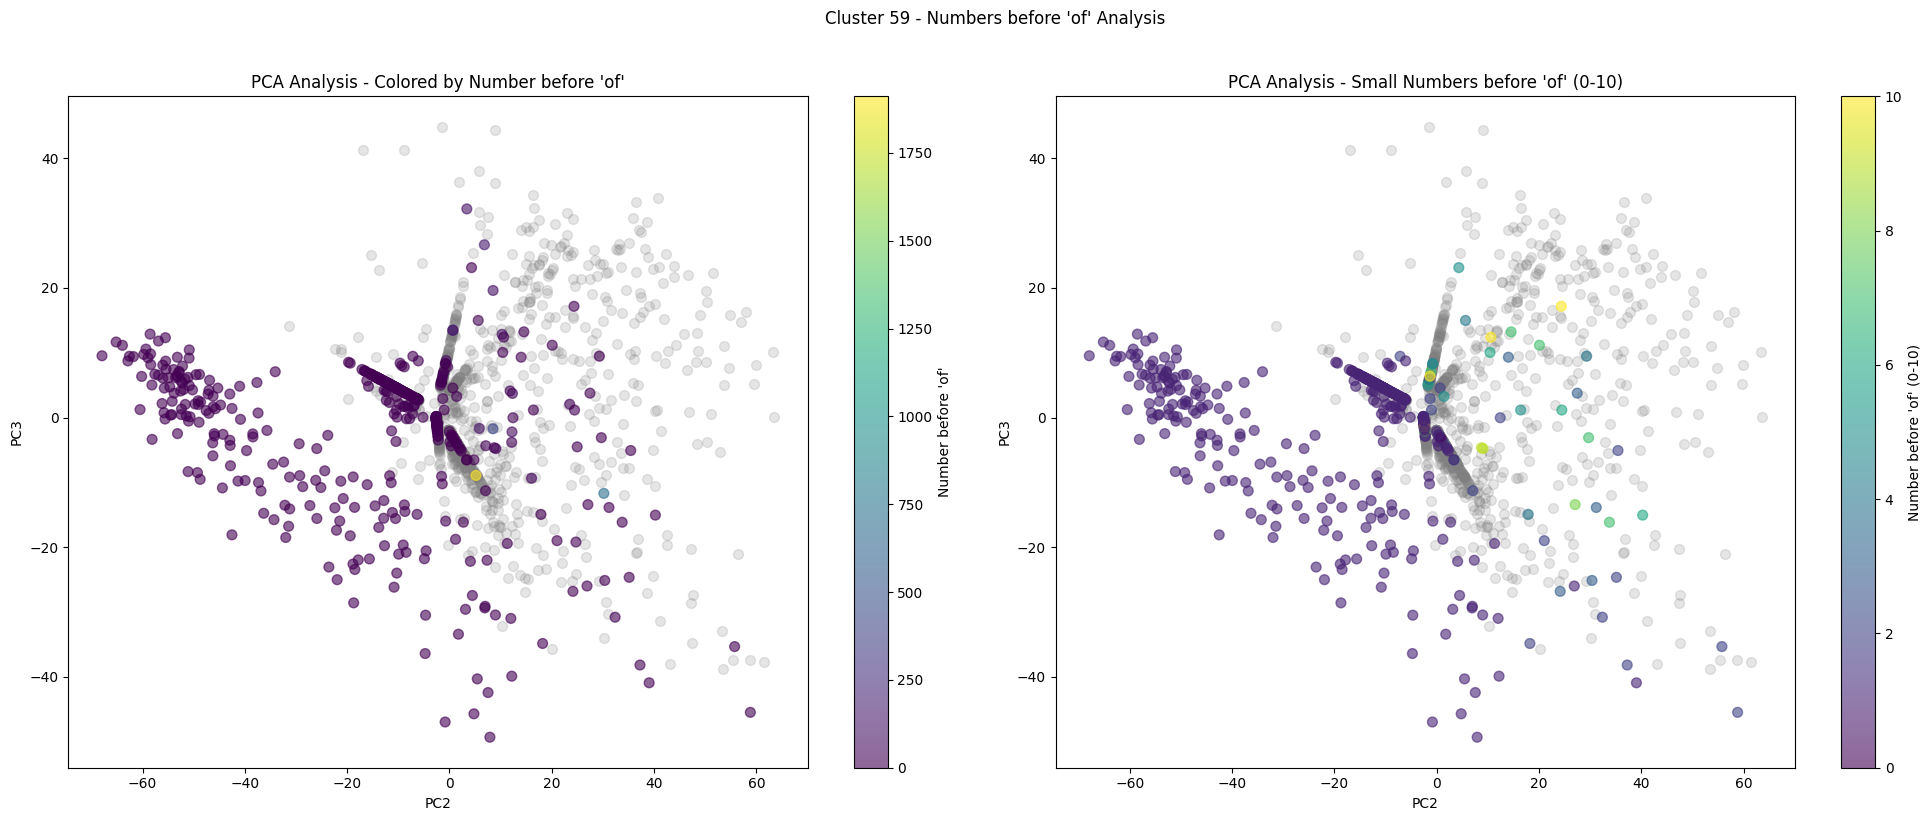

In [9]:
def plot_pca_numbers_before_of(pca_df, pca_path, fs_splitting_cluster, save_figs=False):
    import re

    import matplotlib.pyplot as plt

    # Function to extract number before "of"
    def extract_number_before_of(context):
        context = context.replace("|", " ")

        # Dictionary to convert written numbers to digits
        number_map = {
            "zero": 0,
            "one": 1,
            "two": 2,
            "three": 3,
            "four": 4,
            "five": 5,
            "six": 6,
            "seven": 7,
            "eight": 8,
            "nine": 9,
            "ten": 10,
        }

        # Look for patterns like "number of" or "written_number of"
        # First try to find digit followed by "of"
        digit_match = re.search(r"\b(\d+)\s+of\b", context.lower())
        if digit_match:
            return int(digit_match.group(1))

        # Then try to find written number followed by "of"
        word_match = re.search(
            r"\b(" + "|".join(number_map.keys()) + r")\s+of\b", context.lower()
        )
        if word_match:
            return number_map[word_match.group(1)]

        return None

    # Clean context and extract numbers
    pca_df["cleaned_context"] = pca_df["context"].str.replace("<|endoftext|>", "")
    pca_df["number_before_of"] = pca_df["cleaned_context"].apply(
        extract_number_before_of
    )

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot 1: All points with numbers
    non_number_mask = pca_df["number_before_of"].isna()
    ax1.scatter(
        pca_df.loc[non_number_mask, "PC2"],
        pca_df.loc[non_number_mask, "PC3"],
        color="grey",
        alpha=0.2,
        s=50,
        label="No number before 'of'",
    )

    number_mask = ~non_number_mask
    if number_mask.any():
        scatter1 = ax1.scatter(
            pca_df.loc[number_mask, "PC2"],
            pca_df.loc[number_mask, "PC3"],
            c=pca_df.loc[number_mask, "number_before_of"],
            cmap="viridis",
            alpha=0.6,
            s=50,
        )
        plt.colorbar(scatter1, ax=ax1, label="Number before 'of'")

    ax1.set_title("PCA Analysis - Colored by Number before 'of'")
    ax1.set_xlabel("PC2")
    ax1.set_ylabel("PC3")

    # Plot 2: Small numbers only (0-10)
    small_numbers_mask = pca_df["number_before_of"].between(0, 10)
    ax2.scatter(
        pca_df.loc[non_number_mask, "PC2"],
        pca_df.loc[non_number_mask, "PC3"],
        color="grey",
        alpha=0.2,
        s=50,
        label="No number before 'of'",
    )

    if small_numbers_mask.any():
        scatter2 = ax2.scatter(
            pca_df.loc[small_numbers_mask, "PC2"],
            pca_df.loc[small_numbers_mask, "PC3"],
            c=pca_df.loc[small_numbers_mask, "number_before_of"],
            cmap="viridis",
            alpha=0.6,
            s=50,
        )
        plt.colorbar(scatter2, ax=ax2, label="Number before 'of' (0-10)")

    ax2.set_title("PCA Analysis - Small Numbers before 'of' (0-10)")
    ax2.set_xlabel("PC2")
    ax2.set_ylabel("PC3")

    plt.suptitle(
        f"Cluster {fs_splitting_cluster} - Numbers before 'of' Analysis", y=1.02
    )
    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/pca_plot_numbers_before_of_static_{fs_splitting_cluster}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()


# Call the function
plot_pca_numbers_before_of(pca_df, pca_path, fs_splitting_cluster, save_figs)

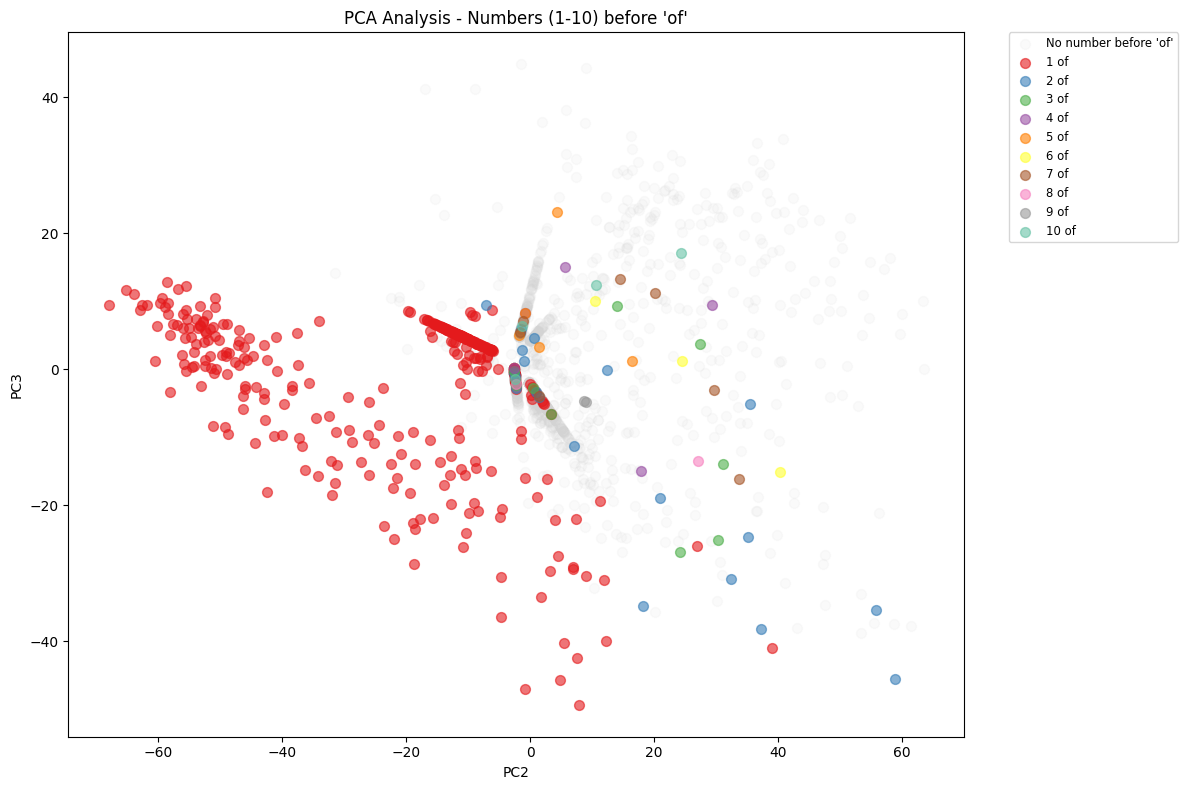

In [10]:
def plot_pca_numbers_before_of(pca_df, pca_path, fs_splitting_cluster, save_figs=False):
    import re

    import matplotlib.pyplot as plt

    # Function to extract number before "of"
    def extract_number_before_of(context):
        context = context.replace("|", " ")

        # Dictionary to convert written numbers to digits
        number_map = {
            "zero": 0,
            "one": 1,
            "two": 2,
            "three": 3,
            "four": 4,
            "five": 5,
            "six": 6,
            "seven": 7,
            "eight": 8,
            "nine": 9,
            "ten": 10,
        }

        # First try to find digit followed by "of"
        digit_match = re.search(r"\b(\d+)\s+of\b", context.lower())
        if digit_match:
            return int(digit_match.group(1))

        # Then try to find written number followed by "of"
        word_match = re.search(
            r"\b(" + "|".join(number_map.keys()) + r")\s+of\b", context.lower()
        )
        if word_match:
            return number_map[word_match.group(1)]

        return None

    # Clean context and extract numbers
    pca_df["cleaned_context"] = pca_df["context"].str.replace("<|endoftext|>", "")
    pca_df["number_before_of"] = pca_df["cleaned_context"].apply(
        extract_number_before_of
    )

    # Create figure
    plt.figure(figsize=(12, 8))

    # Define distinct colors for numbers 1-10
    colors = [
        "#e41a1c",  # red
        "#377eb8",  # blue
        "#4daf4a",  # green
        "#984ea3",  # purple
        "#ff7f00",  # orange
        "#ffff33",  # yellow
        "#a65628",  # brown
        "#f781bf",  # pink
        "#999999",  # grey
        "#66c2a5",  # mint
    ]

    # Plot background points (no number before 'of')
    non_number_mask = pca_df["number_before_of"].isna()
    plt.scatter(
        pca_df.loc[non_number_mask, "PC2"],
        pca_df.loc[non_number_mask, "PC3"],
        color="lightgrey",
        alpha=0.1,
        s=50,
        label="No number before 'of'",
    )

    # Plot each number with its unique color
    for i, color in enumerate(colors, start=1):
        mask = pca_df["number_before_of"] == i
        if mask.any():
            plt.scatter(
                pca_df.loc[mask, "PC2"],
                pca_df.loc[mask, "PC3"],
                c=[color],
                alpha=0.6,
                s=50,
                label=f"{i} of",
            )

    plt.title("PCA Analysis - Numbers (1-10) before 'of'")
    plt.xlabel("PC2")
    plt.ylabel("PC3")

    # Adjust legend
    plt.legend(
        bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0, fontsize="small"
    )

    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/pca_plot_numbers_before_of_static_{fs_splitting_cluster}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()


# Call the function
plot_pca_numbers_before_of(pca_df, pca_path, fs_splitting_cluster, save_figs)

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_14475/3214168627.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"{correlations[i]:.2f}",


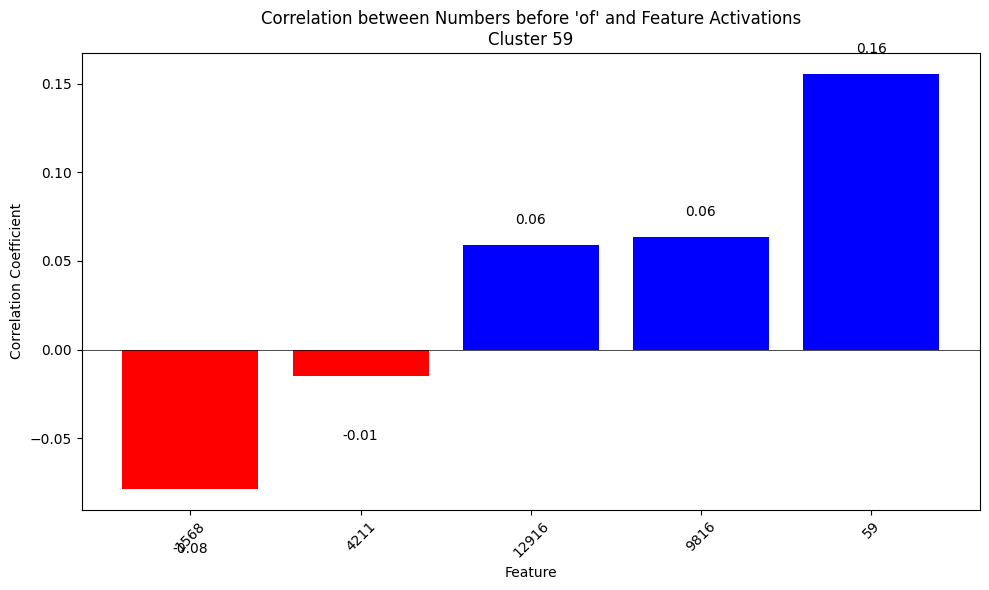


Correlation values:
Feature 1568: -0.078
Feature 4211: -0.015
Feature 12916: 0.059
Feature 9816: 0.063
Feature 59: 0.156


In [20]:
def plot_number_feature_correlations(
    pca_df, results, fs_splitting_nodes, pca_path, fs_splitting_cluster, save_figs=False
):
    import matplotlib.pyplot as plt
    import pandas as pd

    # Get feature activations
    feature_activations = pd.DataFrame(
        results.all_graph_feature_acts.cpu().numpy(),
        columns=[f"Feature {i}" for i in fs_splitting_nodes],
    )

    # Combine with numbers before 'of'
    correlation_df = pd.concat(
        [feature_activations, pca_df["number_before_of"]], axis=1
    )

    # Calculate correlations only for rows where we have a number
    valid_rows = correlation_df["number_before_of"].notna()
    correlations = (
        correlation_df[valid_rows].corr()["number_before_of"].drop("number_before_of")
    )

    # Create figure
    plt.figure(figsize=(10, 6))

    # Plot correlation bars
    bars = plt.bar(
        range(len(correlations)),
        correlations,
        color=["red" if x < 0 else "blue" for x in correlations],
    )

    # Customize plot
    plt.axhline(y=0, color="black", linestyle="-", linewidth=0.5)
    plt.title(
        f"Correlation between Numbers before 'of' and Feature Activations\nCluster {fs_splitting_cluster}"
    )
    plt.xlabel("Feature")
    plt.ylabel("Correlation Coefficient")

    # Add feature labels
    plt.xticks(
        range(len(correlations)), [f"{i}" for i in fs_splitting_nodes], rotation=45
    )

    # Add correlation values on top of bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + (0.01 if height >= 0 else -0.03),
            f"{correlations[i]:.2f}",
            ha="center",
            va="bottom" if height >= 0 else "top",
            rotation=0,
        )

    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/number_feature_correlations_{fs_splitting_cluster}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()

    # Print the actual correlation values
    print("\nCorrelation values:")
    for node, corr in zip(fs_splitting_nodes, correlations):
        print(f"Feature {node}: {corr:.3f}")


# Call the function
plot_number_feature_correlations(
    pca_df, results, fs_splitting_nodes, pca_path, fs_splitting_cluster, save_figs
)

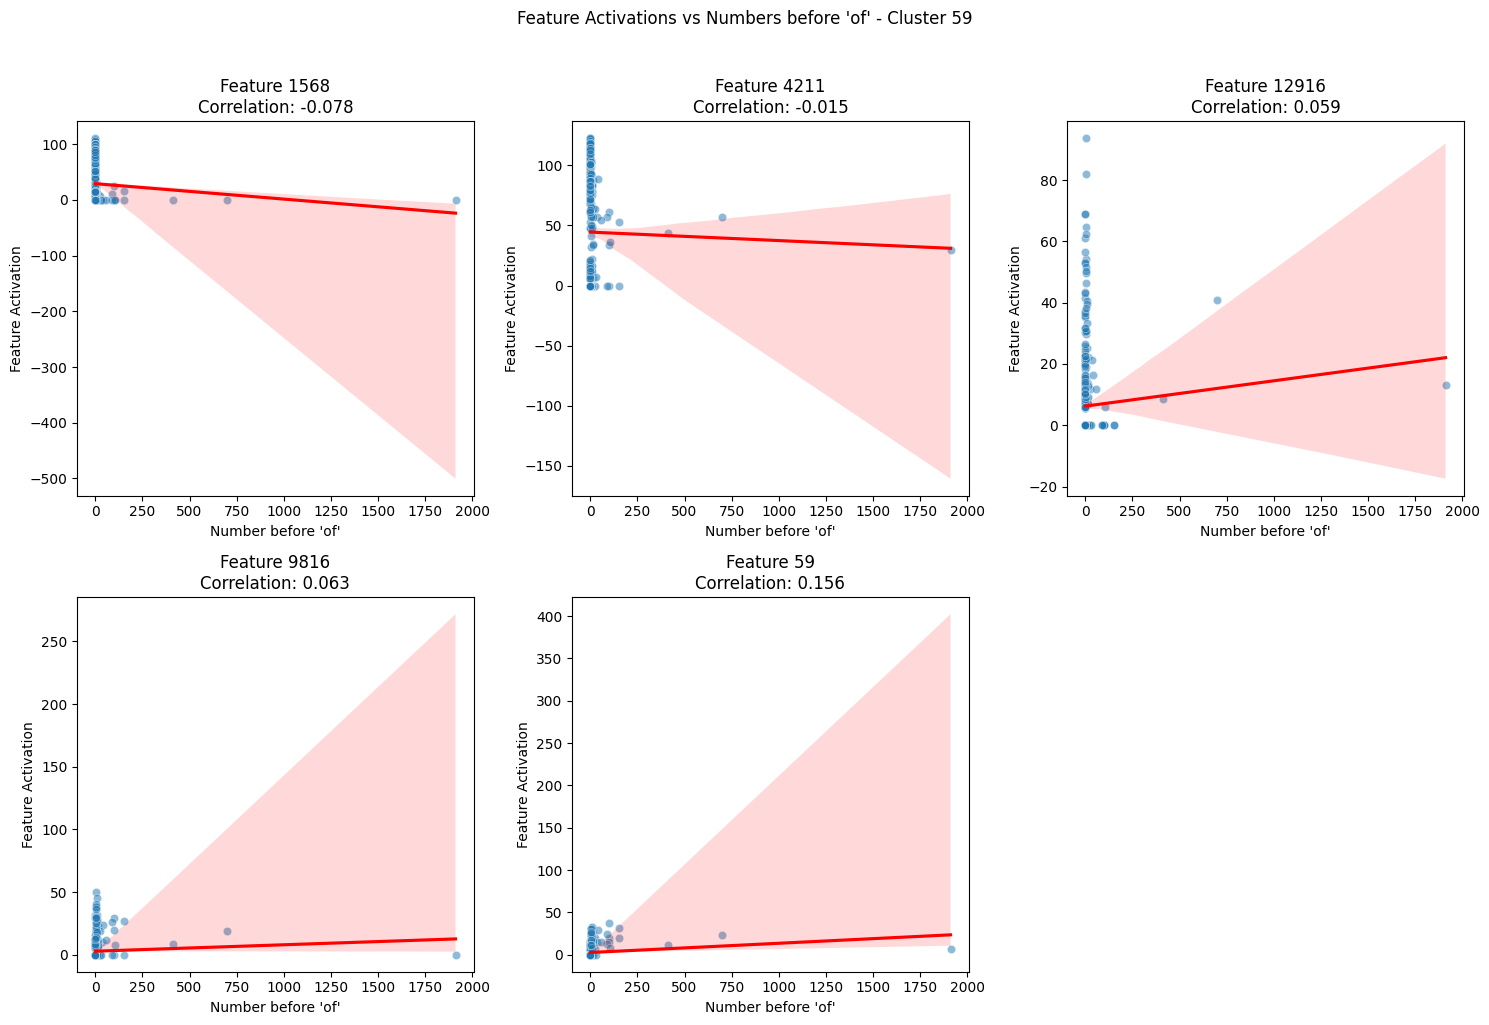

In [21]:
def plot_feature_number_scatter(
    pca_df, results, fs_splitting_nodes, pca_path, fs_splitting_cluster, save_figs=False
):
    import matplotlib.pyplot as plt
    import pandas as pd
    import seaborn as sns

    # Get feature activations
    feature_activations = pd.DataFrame(
        results.all_graph_feature_acts.cpu().numpy(),
        columns=[f"Feature {i}" for i in fs_splitting_nodes],
    )

    # Combine with numbers before 'of'
    analysis_df = pd.concat([feature_activations, pca_df["number_before_of"]], axis=1)

    # Filter for valid numbers
    valid_df = analysis_df[analysis_df["number_before_of"].notna()]

    # Create subplot grid
    n_features = len(fs_splitting_nodes)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    # Plot each feature
    for idx, feature_id in enumerate(fs_splitting_nodes):
        ax = axes[idx]
        feature_col = f"Feature {feature_id}"

        # Create scatter plot
        sns.scatterplot(
            data=valid_df, x="number_before_of", y=feature_col, ax=ax, alpha=0.5
        )

        # Add trend line
        sns.regplot(
            data=valid_df,
            x="number_before_of",
            y=feature_col,
            ax=ax,
            scatter=False,
            color="red",
        )

        # Calculate correlation
        corr = valid_df[[feature_col, "number_before_of"]].corr().iloc[0, 1]

        ax.set_title(f"Feature {feature_id}\nCorrelation: {corr:.3f}")
        ax.set_xlabel("Number before 'of'")
        ax.set_ylabel("Feature Activation")

    # Remove empty subplots
    for idx in range(len(fs_splitting_nodes), len(axes)):
        fig.delaxes(axes[idx])

    plt.suptitle(
        f"Feature Activations vs Numbers before 'of' - Cluster {fs_splitting_cluster}",
        y=1.02,
    )
    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/feature_number_scatter_{fs_splitting_cluster}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()


# Call the function
plot_feature_number_scatter(
    pca_df, results, fs_splitting_nodes, pca_path, fs_splitting_cluster, save_figs
)

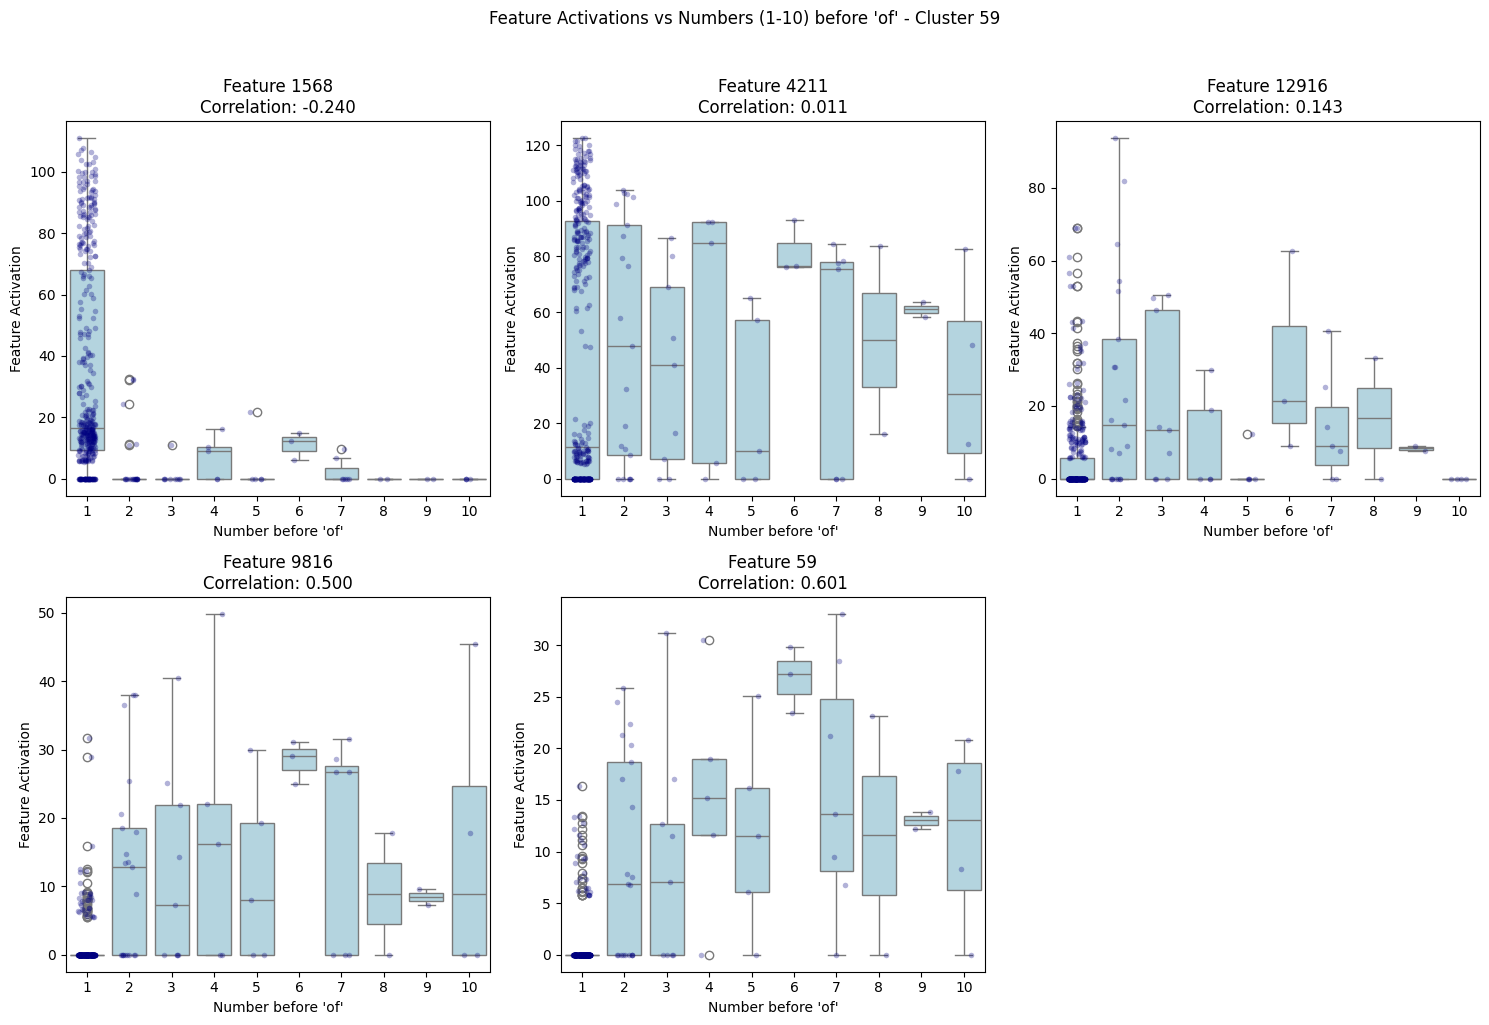

In [22]:
def plot_feature_number_scatter(
    pca_df, results, fs_splitting_nodes, pca_path, fs_splitting_cluster, save_figs=False
):
    import matplotlib.pyplot as plt
    import pandas as pd
    import seaborn as sns

    # Get feature activations
    feature_activations = pd.DataFrame(
        results.all_graph_feature_acts.cpu().numpy(),
        columns=[f"Feature {i}" for i in fs_splitting_nodes],
    )

    # Combine with numbers before 'of'
    analysis_df = pd.concat([feature_activations, pca_df["number_before_of"]], axis=1)

    # Filter for valid numbers between 1 and 10
    valid_df = analysis_df[
        analysis_df["number_before_of"].between(1, 10, inclusive="both")
    ]

    # Create subplot grid
    n_features = len(fs_splitting_nodes)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    # Plot each feature
    for idx, feature_id in enumerate(fs_splitting_nodes):
        ax = axes[idx]
        feature_col = f"Feature {feature_id}"

        # Create box plot
        sns.boxplot(
            data=valid_df,
            x="number_before_of",
            y=feature_col,
            ax=ax,
            color="lightblue",
        )

        # Add individual points
        sns.stripplot(
            data=valid_df,
            x="number_before_of",
            y=feature_col,
            ax=ax,
            color="navy",
            alpha=0.3,
            size=4,
            jitter=0.2,
        )

        # Calculate correlation
        corr = valid_df[[feature_col, "number_before_of"]].corr().iloc[0, 1]

        ax.set_title(f"Feature {feature_id}\nCorrelation: {corr:.3f}")
        ax.set_xlabel("Number before 'of'")
        ax.set_ylabel("Feature Activation")

        # Set x-axis ticks to whole numbers 1-10
        ax.set_xticks(range(10))
        ax.set_xticklabels(range(1, 11))

    # Remove empty subplots
    for idx in range(len(fs_splitting_nodes), len(axes)):
        fig.delaxes(axes[idx])

    plt.suptitle(
        f"Feature Activations vs Numbers (1-10) before 'of' - Cluster {fs_splitting_cluster}",
        y=1.02,
    )
    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/feature_number_scatter_1_10_{fs_splitting_cluster}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()


# Call the function
plot_feature_number_scatter(
    pca_df, results, fs_splitting_nodes, pca_path, fs_splitting_cluster, save_figs
)

In [13]:
pca_df.head()

,PC1,PC2,PC3,tokens,context,point_id
0,-23.655930,-8.545183,3.790835,one,.\n\nConcept\n\nWorking over the theme was pro...,0
1,109.980759,-52.426998,0.452910,of,\n\nConcept\n\nWorking over the theme was prob...,1
2,-21.717014,-10.520233,4.628265,the,Concept\n\nWorking over the theme was probably...,2
3,-26.918034,1.174350,-3.715866,many,"face. And judging by the entries submitted, n...",3
4,95.849838,7.540532,-42.454834,of,"attempt, unable to conquer the plate, until o...",4


In [14]:
def extract_number_contexts(pca_df):
    import re

    # Function to check if context has number before 'of'
    def has_number_before_of(context):
        # Convert to lowercase and replace pipes
        context = context.replace("|", " ").lower()

        # Dictionary for written numbers
        number_map = {
            "zero": 0,
            "one": 1,
            "two": 2,
            "three": 3,
            "four": 4,
            "five": 5,
            "six": 6,
            "seven": 7,
            "eight": 8,
            "nine": 9,
            "ten": 10,
        }

        # Check for digit followed by "of"
        digit_match = re.search(r"\b(\d+)\s+of\b", context)
        if digit_match:
            return True

        # Check for written number followed by "of"
        word_pattern = r"\b(" + "|".join(number_map.keys()) + r")\s+of\b"
        word_match = re.search(word_pattern, context)
        if word_match:
            return True

        return False

    # Filter contexts
    number_contexts = pca_df[pca_df["context"].apply(has_number_before_of)]["context"]

    # Clean and format output
    cleaned_contexts = number_contexts.str.replace("<|endoftext|>", "").str.strip()

    return cleaned_contexts


# Use the function
number_contexts = extract_number_contexts(pca_df)

# Print first few examples
print(f"Found {len(number_contexts)} contexts with numbers before 'of'")
print("\nFirst few examples:")
for ctx in number_contexts.head():
    print(f"\n{ctx}")

Found 490 contexts with numbers before 'of'

First few examples:

.

Concept

Working over the theme was probably| one| of the hardest tasks I had to face.

Concept

Working over the theme was probably one| of| the hardest tasks I had to face.

Originally

Concept

Working over the theme was probably one of| the| hardest tasks I had to face.

Originally,

attempt, unable to conquer the plate, until one| of| them die (think Battlefield’s standard “Con

coding for the most time. But livestreaming is| one| of the cool things to do as a spectator too


In [15]:
def expand_number_contexts(number_contexts):
    import re

    # Dictionary for written numbers and their variations
    number_map = {
        "0": ["zero", "0"],
        "1": ["one", "1"],
        "2": ["two", "2"],
        "3": ["three", "3"],
        "4": ["four", "4"],
        "5": ["five", "5"],
        "6": ["six", "6"],
        "7": ["seven", "7"],
        "8": ["eight", "8"],
        "9": ["nine", "9"],
        "10": ["ten", "10"],
    }

    expanded_contexts = []

    for context in number_contexts:
        # First find the original number and 'of'
        context_lower = context.lower()

        # Try to find digit pattern first
        digit_match = re.search(r"\b(\d+)\s+of\b", context_lower)

        # If no digit found, try written numbers
        if not digit_match:
            word_pattern = (
                r"\b("
                + "|".join(sum([nums for nums in number_map.values()], []))
                + r")\s+of\b"
            )
            word_match = re.search(word_pattern, context_lower)
            if word_match:
                # original_number = word_match.group(1)
                start_idx = word_match.start(1)
                end_idx = word_match.end(1)
            else:
                continue
        else:
            # original_number = digit_match.group(1)
            start_idx = digit_match.start(1)
            end_idx = digit_match.end(1)

        # Generate variations for numbers 1-10
        for i in range(1, 11):
            # Use the written form of the number
            new_number = number_map[str(i)][0]  # Use written form

            # Create new context with replaced number
            new_context = context[:start_idx] + new_number + context[end_idx:]
            expanded_contexts.append(new_context)

    return expanded_contexts


# Use the function
expanded_contexts = expand_number_contexts(number_contexts)

# Print some examples to verify
print(f"Original contexts: {len(number_contexts)}")
print(f"Expanded contexts: {len(expanded_contexts)}")
print("\nExample expansions for first context:")
for i in range(10):
    print(f"\n{expanded_contexts[i]}")

Original contexts: 490
Expanded contexts: 1670

Example expansions for first context:

Concept

Working over the theme was probably one of| the| hardest tasks I had to face.

Originally,

Concept

Working over the theme was probably two of| the| hardest tasks I had to face.

Originally,

Concept

Working over the theme was probably three of| the| hardest tasks I had to face.

Originally,

Concept

Working over the theme was probably four of| the| hardest tasks I had to face.

Originally,

Concept

Working over the theme was probably five of| the| hardest tasks I had to face.

Originally,

Concept

Working over the theme was probably six of| the| hardest tasks I had to face.

Originally,

Concept

Working over the theme was probably seven of| the| hardest tasks I had to face.

Originally,

Concept

Working over the theme was probably eight of| the| hardest tasks I had to face.

Originally,

Concept

Working over the theme was probably nine of| the| hardest tasks I had to face.

Original

In [17]:
def expand_number_contexts(number_contexts):
    import re

    # Dictionary for written numbers only
    number_words = {
        "1": "one",
        "2": "two",
        "3": "three",
        "4": "four",
        "5": "five",
        "6": "six",
        "7": "seven",
        "8": "eight",
        "9": "nine",
        "10": "ten",
    }

    expanded_contexts = []

    for context in number_contexts:
        context_lower = context.lower()

        # Only look for written number words
        word_pattern = r"\b(" + "|".join(number_words.values()) + r")\s+of\b"
        word_match = re.search(word_pattern, context_lower)

        if word_match:
            # original_number = word_match.group(1)
            start_idx = word_match.start(1)
            end_idx = word_match.end(1)

            # Generate variations for numbers 1-10
            for i in range(1, 11):
                new_number = number_words[str(i)]
                new_context = context[:start_idx] + new_number + context[end_idx:]
                expanded_contexts.append(new_context)

    return expanded_contexts


# Use the function
expanded_contexts = expand_number_contexts(number_contexts)

# Print some examples to verify
print(f"Original contexts: {len(number_contexts)}")
print(f"Expanded contexts: {len(expanded_contexts)}")
print("\nExample expansions for first context:")
for i in range(10):
    print(f"\n{expanded_contexts[i]}")

# Optionally save to CSV
pd.DataFrame(expanded_contexts).to_csv(
    f"{pca_path}/expanded_contexts_{fs_splitting_cluster}.csv", index=False
)

Original contexts: 490
Expanded contexts: 1510

Example expansions for first context:

Concept

Working over the theme was probably one of| the| hardest tasks I had to face.

Originally,

Concept

Working over the theme was probably two of| the| hardest tasks I had to face.

Originally,

Concept

Working over the theme was probably three of| the| hardest tasks I had to face.

Originally,

Concept

Working over the theme was probably four of| the| hardest tasks I had to face.

Originally,

Concept

Working over the theme was probably five of| the| hardest tasks I had to face.

Originally,

Concept

Working over the theme was probably six of| the| hardest tasks I had to face.

Originally,

Concept

Working over the theme was probably seven of| the| hardest tasks I had to face.

Originally,

Concept

Working over the theme was probably eight of| the| hardest tasks I had to face.

Originally,

Concept

Working over the theme was probably nine of| the| hardest tasks I had to face.

Original

In [18]:
# filter rows that do not contain ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']
expanded_contexts = [
    ctx
    for ctx in expanded_contexts
    if any(
        word in ctx.lower()
        for word in [
            "one",
            "two",
            "three",
            "four",
            "five",
            "six",
            "seven",
            "eight",
            "nine",
            "ten",
        ]
    )
]

In [23]:
# save as pickle_file
with open(f"{pca_path}/expanded_contexts_{fs_splitting_cluster}.pkl", "wb") as f:
    pickle.dump(expanded_contexts, f)